In [ ]:
import numpy as np
import scipy as sp
import scipy.stats as st
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib as mp
mp.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt
# force inline plots
# %matplotlib inline
plt.style.use('seaborn-deep')
import torch.nn as nn
import copy
import pandas as pd
import sys
import os
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set a seed to ensure reproducibility
# seed = 128
# rnd  = np.random.RandomState(seed)
def DR(s, theta):
    return sp.special.gammainc(s, theta)

def DL(s, theta):
    return 1 - sp.special.gammainc(s+1, theta)
from IPython.display import Image, display
# algorithm2 = Image('src/images/Algorithm2.jpg')
# display(algorithm2)

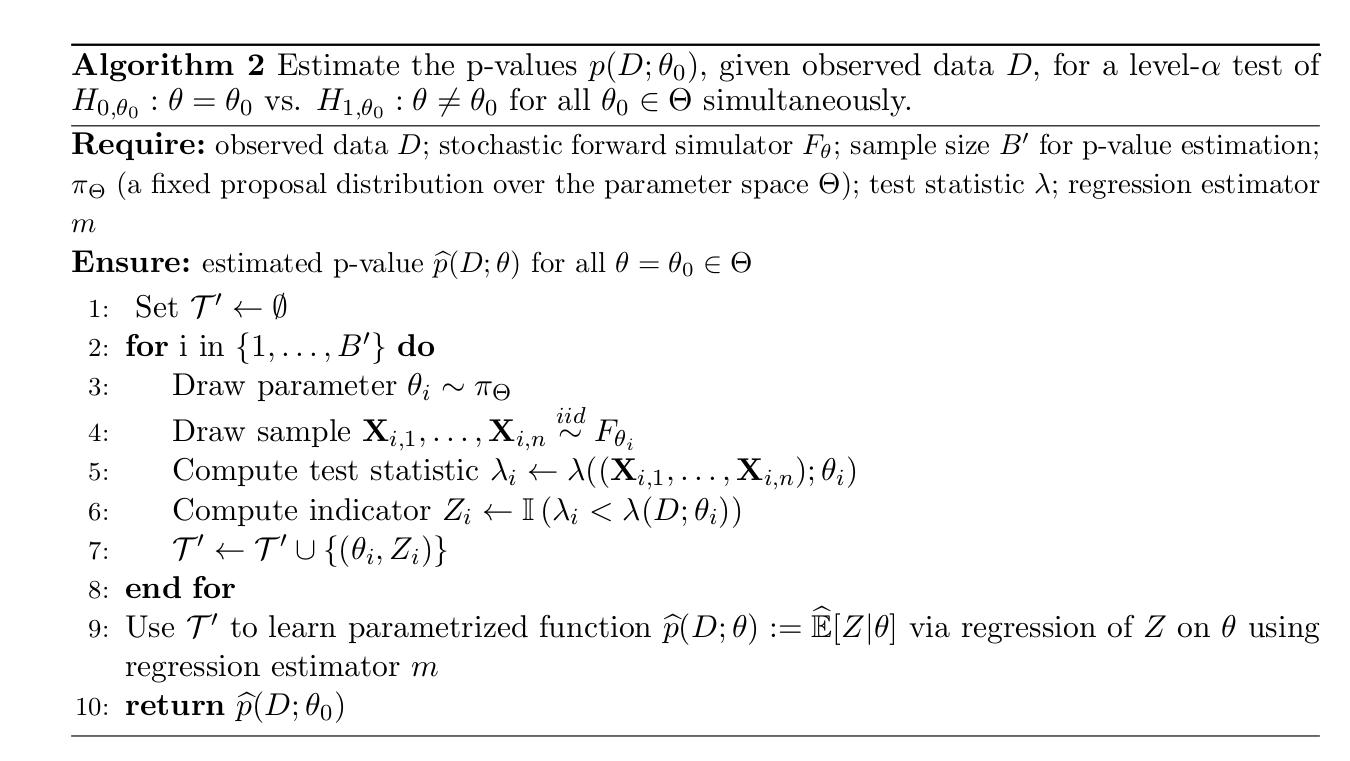

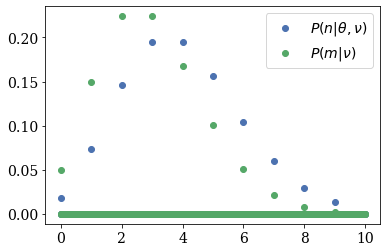

(3, 0)
(2, 2)
(1, 3)
(3, 0)
(1, 3)
(1, 2)


GenerateData_and_Train_2_parameters_step_1.ipynb:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  "M & \\sim \\textrm{uniform}(0, 10), \\textrm{ and } \\\\\n",


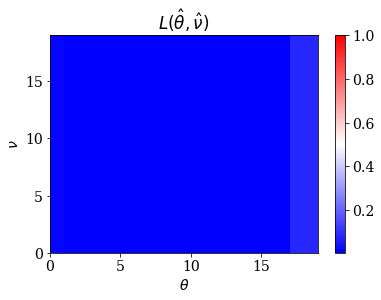

<Figure size 720x432 with 0 Axes>

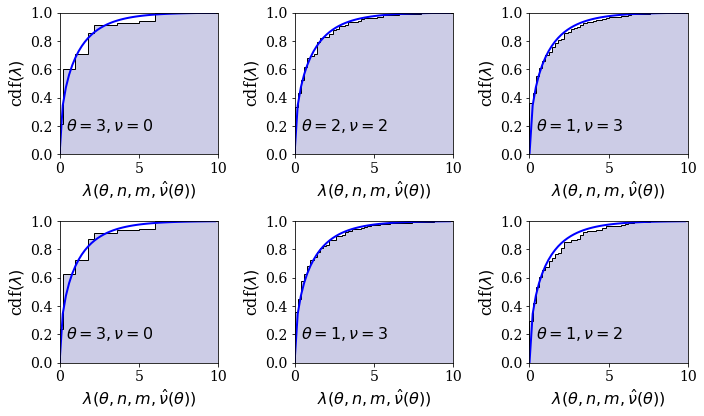

n= [28 23 46 ... 58 42 49]
m= [11  7 12 ... 10 26 29]
N= [24 15 13 ... 29 22 26]
M= [ 6  3  9 ... 16 29  6]
lambda_gen=  [0.02007854 0.11235987 0.34449631 ... 2.48272255 0.66578972 0.02055718]
lambda_D=  [ 0.12095664  0.25037899 32.20806893 ...  9.57243594  5.10855614
  0.0494166 ]
   Z      theta         nu   N   M
0  1  16.117913  13.189346  24   6
1  1  14.182669   8.047466  15   3
2  1  38.541682  12.223957  13   9
3  1  17.899751  17.327143   7  22
4  1   7.148156  13.387594   6  18


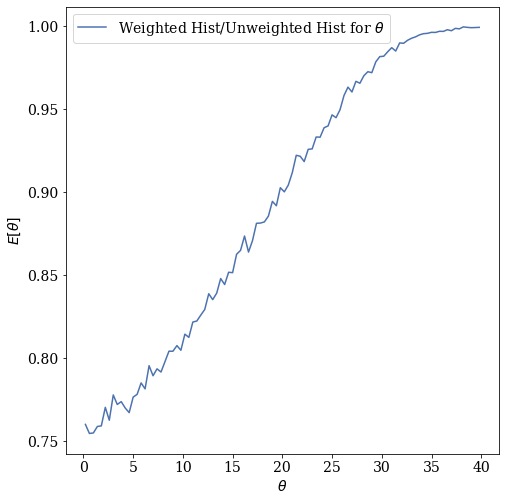

train set size:        980392
validation set size:     9804
test set size:           9804
Model(
  (layer0): Linear(in_features=4, out_features=20, bias=True)
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=1, bias=True)
)
Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.238274	  0.237243
     19990	  0.047487	  0.046669
Iteration vs average loss
 iteration	 train-set	 valid-set
     29990	  0.046495	  0.045976


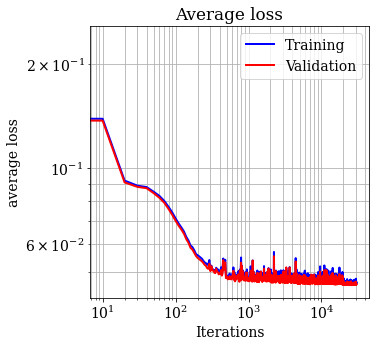

torch.Size([1000000])


In [ ]:
%run GenerateData_and_Train_2_parameters_step_1.ipynb

In [3]:
# datafile = pd.read_csv('data/results/INFERENCE_DF_TWOPARAMS_1M.csv')
# data=datafile[['Z', 'theta', 'nu', 'N', 'M', 'phat']]
# data.head()

In [3]:
model = torch.load('models/Regressor_TwoParams_theta_nu_m_n.pth'); model.parameters

<bound method Module.parameters of Model(
  (layer0): Linear(in_features=4, out_features=20, bias=True)
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=1, bias=True)
)>

### Recall that the goal is to approximate $\lambda$ by estimating the distribution $P(\lambda_{\text{gen}}<\lambda_D)$. 

We start off by using $\hat{\theta}_{MLE}$ since we have an analytical expression for the CDF of $\lambda$ in that case. 


$\hat{p}(\theta,\nu,N,M)$

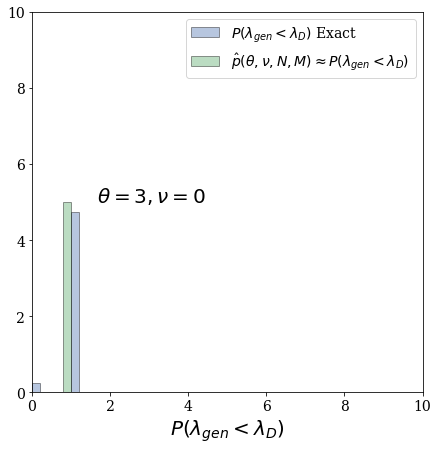

In [68]:
def plot_one(p_lambda_gen_lt_lambda_D, PHAT, theta, nu, ax):
    ftsize = 20
    xmin, xmax= 0, 10
    ymin, ymax = 0, 10
    x_range = (xmin, xmax)
    y_range = (ymin, ymax)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_xlabel(r'$P(\lambda_{gen}<\lambda_D)$',fontsize=ftsize)
    ax.hist(p_lambda_gen_lt_lambda_D, bins=5*xmax, range=x_range, density=True,
            alpha=0.4, histtype='stepfilled', edgecolor='black', label=r'$P(\lambda_{gen}<\lambda_D)$ Exact')
    ax.hist(PHAT, bins=5*xmax, range=x_range, density=True,
            alpha=0.4, histtype='stepfilled', edgecolor='black',label=r'$\hat{p}(\theta,\nu,N,M) \approx P(\lambda_{gen}<\lambda_D)$ ')
    
    
    #positions for text
    xwid = (xmax-xmin)/12
    ywid = (ymax-ymin)/12
    xpos = xmin + xwid*2
    ypos = ymin + ywid*6
    ax.text(xpos, ypos,
    r'$ \theta = %d, \nu = %d$' % (theta, nu),
    fontsize=ftsize)
    
    ax.legend()
    
theta, nu= 3, 0
n = st.poisson.rvs(theta+ nu, size=Bprime)
m = st.poisson.rvs(nu, size=Bprime)
lambda_gen = lambda_test(theta, n, m, MLE)
lambda_D = lambda_test(theta, N, M, MLE)
P_exact = (lambda_gen <= lambda_D).astype(np.int32)
# plt.hist(P_exact,bins=50, label=r'$P(\lambda_{gen}<\lambda_D)$ Exact',alpha=0.35)
#order of features for the model:['theta', 'nu', 'N', 'M']
X = [theta, nu, N, M]
with torch.no_grad():
    model.eval()

    X = torch.Tensor(X)
    phat = model(X)
    phat = phat.detach().flatten()
    # phat=phat.numpy()
    PHAT = phat.view(-1).numpy()
# plt.hist(PHAT, bins=50, label=r'$\hat{p}(\theta,\nu,N,M) \approx P(\lambda_{gen}<\lambda_D)$ ', alpha=0.35)
# plt.legend()
fig, ax = plt.subplots(1, 1, figsize=(7,7))

plot_one(P_exact, PHAT, theta, nu, ax)

In [73]:
#FIX N AND M and theta and nu
Bprime=1000
N, M = 1, 2

def sim_nm_lambdas(theta, nu):
    """Sample n ~ Pois(theta+nu), m ~ Pois(nu), and compute lambda_gen(theta, n, m) and lambda_D(theta, N, mM)
    return (n, m, lambda_gen, lambda_D"""
    n = st.poisson.rvs(theta+nu, size=Bprime)
    m = st.poisson.rvs(nu, size=Bprime)
    lambda_gen = lambda_test(theta, n, m, MLE)
    lambda_D = lambda_test(theta, N, M, MLE)
    return (n, m, lambda_gen, lambda_D)
    
# points =(theta, nu)
def sim_nm_lambdas_diff_theta_nu(points):
    """for each theta and nu tuple, generate n,m, lambda_gen, lambda_D
    then calculate P(\lambda_{gen}<\lambda_D)$ Exact and \hat{p}(\theta,\nu,N,M) \approx P(\lambda_{gen}<\lambda_D)"""
    results_list = []
    for p in points:
        theta, nu = p
        n, m, lambda_gen, lambda_D = sim_nm_lambdas(theta, nu)
        p_lambda_gen_lt_lambda_D = (lambda_gen <= lambda_D).astype(np.int32)
        X = [theta, nu, N, M]
        with torch.no_grad():
            model.eval()

            X = torch.Tensor(X)
            phat = model(X)
            phat = phat.detach().flatten()
            # phat=phat.numpy()
            PHAT = phat.view(-1).numpy()
        #results will be an array of n, an array of m, an array of lambda_gen, and array of lambda_D
        # an array of P_Exact, an array pf phat
        results_list.append((n, m, lambda_gen, lambda_D, theta, nu, p_lambda_gen_lt_lambda_D, PHAT))
    return results_list


def plot_one(p_lambda_gen_lt_lambda_D, PHAT, theta, nu, ax):
    ftsize = 20
    xmin, xmax= 0, 10
    ymin, ymax = 0, 10
    x_range = (xmin, xmax)
    y_range = (ymin, ymax)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_xlabel(r'$P(\lambda_{gen}<\lambda_D)$',fontsize=ftsize)
    ax.hist(p_lambda_gen_lt_lambda_D, bins=5*xmax, range=x_range, density=True,
            alpha=0.4, histtype='stepfilled', edgecolor='black', label=r'$P(\lambda_{gen}<\lambda_D)$ Exact with $\hat{\theta}_{MLE}$')
    ax.hist(PHAT, bins=5*xmax, range=x_range, density=True,
            alpha=0.4, histtype='stepfilled', edgecolor='black',label=r'$\hat{p}(\theta,\nu,N,M) \approx P(\lambda_{gen}<\lambda_D)$ ')
    
    
    #positions for text
    xwid = (xmax-xmin)/12
    ywid = (ymax-ymin)/12
    xpos = xmin + xwid*2
    ypos = ymin + ywid*6
    ax.text(xpos, ypos,
    r'$ \theta = %d, \nu = %d$' % (theta, nu),
    fontsize=ftsize)
    ax.legend()

def plot_all(results, fgsize=(15,15)):
    plt.figure(figsize=fgsize)
    fig, ax = plt.subplots(2, 3, figsize=fgsize)
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.2)
    ax = ax.flatten()
    #result is (n, m, lambda_gen, lambda_D, theta, nu p_lambda_gen_lt_lambda_D, PHAT)
    for i, result in enumerate(results):
        n, m, lambda_gen, lambda_D, theta, nu, p_lambda_gen_lt_lambda_D, PHAT =result
        plot_one(p_lambda_gen_lt_lambda_D, PHAT, theta, nu, ax[i])
        
    for j in range(len(results), len(ax)):
        ax[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

<Figure size 1080x1080 with 0 Axes>

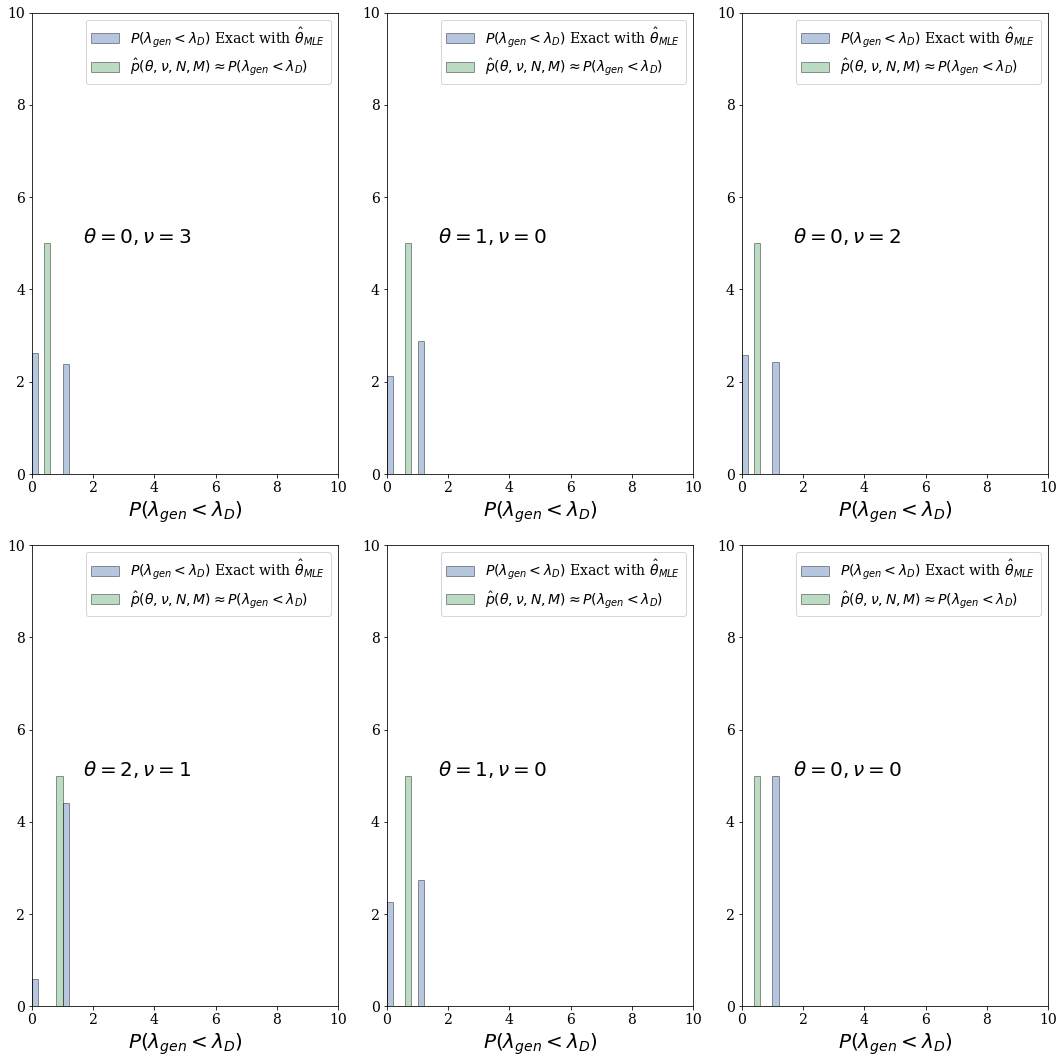

In [74]:
MLE=True
#generate (theta, nu) points
points = [(theta, nu) for theta, nu in 
          zip(np.random.randint(low=0,high=4,size=6), np.random.randint(low=0,high=4,size=6))]
results = sim_nm_lambdas_diff_theta_nu(points)
plot_all(results)

In [23]:
# def hist_data_two_params(data, N, M, x):
#     """Given a dataframe data which has columns theta and M and N, return a histogram of theta at those [M,N] values with the
#     weights Z, divided by a histogram for theta at those D values without the weights. This will be the the approximate p value at bins x. The exact p value for D at x is calculated with DL"""
#     # mask = (data['value2'] == 'some_string') & (data['value'] > 4)
#     mask = (data.M == M) & (data.N == N)

#     # weighted histogram   (count the number of ones per bin)
#     y1, bins = np.histogram(data.theta[mask], 
#                          bins=xbins, 
#                          range=xrange, 
#                          weights=data.Z[mask]) 

#     # unweighted histogram (count number of ones and zeros per bin)
#     yt, _ = np.histogram(data.theta[mask], 
#                          bins=xbins, 
#                          range=xrange)

#     # approximation of DL(D, x)
#     approx_p_by_hist =  y1 / yt    
    
#     bin_centers = (bins[1:]+bins[:-1])/2
#     # exact
#     # exact_p = DL(D, x)
#     # inputs = ['theta', 'nu', 'N', 'M']
#     # df_at_inputs = data[inputs]
#     # df_at_inputs = df_at_inputs[mask]
#     data_at_mask = data[mask]
#     inputs = ['theta', 'nu', 'N', 'M']
#     # data_df='data/two_parameters_N_M_Uniformly_sampled_1M.csv'
#     # df = pd.read_csv(data_df)
#     Input_features = data_at_mask[inputs]
#     ############ ML inference part
#     with torch.no_grad():
#         model.eval()

#         X = torch.Tensor(Input_features.values)
#         phat = model(X)
#         phat = phat.detach().flatten()
#         # phat=phat.numpy()
#         PHAT = phat.view(-1).numpy()
#         print(phat.flatten().shape)

#     # model_at_inputs =data.phat[mask]
#     model_at_inputs = PHAT
    
#     print('\napprox_p by histogramming =',approx_p_by_hist)
#     print('\napprox_p by model =',model_at_inputs)
#     print('\nbin centers=', bin_centers)
#     return approx_p_by_hist, model_at_inputs 